In [1]:
# 16/06/2020
# TASI.AI
# Raphael Mourad

# GARCH model: one issue of ARIMA models is that these autoregressive models 
# do not model a change in the variance over time.
# In the context of a time series in the financial domain, change in the variance would be 
# called increasing and decreasing volatility.
# Specifically, a GARCH models the variance at a time step as a function of 
# the residual errors from a mean process (e.g. a zero mean).

# Tutorials on GARCH:
# https://pyflux.readthedocs.io/en/latest/garch.html
# https://www.quantstart.com/articles/Generalised-Autoregressive-Conditional-Heteroskedasticity-GARCH-p-q-Models-for-Time-Series-Analysis/

# A very good tutorial explaining both ARIMA and GARCH!
# http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

# So GARCH predicts the variance of a time series, not the mean as ARIMA does!
# GARCH works by using as input the residuals (white noise or volatility) of a model such as ARIMA.

###### IMPORT LIBRARIES AND SET UP PARAMETERS

# Import libraries
import os
import pandas as pd
import numpy as np
import pyflux as pf
import seaborn
import matplotlib
import pmdarima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima, ARIMA
from pandas_datareader import DataReader
from datetime import datetime
from matplotlib import pyplot
from scipy.stats import norm
from arch import arch_model

In [2]:
# Set up directory
dir="/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/RamCiri"
os.chdir(dir)
print(os.getcwd())

/media/mourad/diskSave/MCF_Toulouse/recherche/ConsulProj/RamCiri


In [3]:
# Parameters
symbol="GOOG" # Set up the symbol you want
kdays=30 # Number of days for forecasting

In [4]:
# Create folder for symbol
if(os.path.isdir("results/GARCH/")==False):
    os.mkdir("results/GARCH/", mode=0o777)
symbolFolder="results/GARCH/"+symbol
if(os.path.isdir(symbolFolder)==False):
    os.mkdir(symbolFolder, mode=0o777)

In [5]:
###### LOAD AND PREPROCESS DATA

# Import price
path="data/stockquotes/samples_L3_stockquotes_sample.csv.gz"
data_stockquotes = pd.read_csv(path, compression='gzip', header=0, sep=',', quotechar='"', error_bad_lines=False)
data_stockquotes["quotedate"] = pd.to_datetime(data_stockquotes["quotedate"])
#print(data_stockquotes)
#print(np.unique(data_stockquotes["symbol"]))

In [6]:
# Choose the stock
data_stockquotes_sel=data_stockquotes[data_stockquotes["symbol"]==symbol]
data_stockquotes_sel=data_stockquotes_sel.sort_values('quotedate')
data_stockquotes_sel=data_stockquotes_sel.set_index('quotedate')
#print(data_stockquotes_sel)

In [7]:
# Check the absence of missing data 
NAcount=data_stockquotes.isnull().sum().sum()
print("Missing data=",NAcount)

Missing data= 0


In [8]:
# Extract close price
priceClose=data_stockquotes_sel["close"]
print(priceClose)

quotedate
2015-05-01     537.900024
2015-05-04     540.780029
2015-05-05     530.799988
2015-05-06     524.219971
2015-05-07     530.700012
                 ...     
2020-05-22    1410.420000
2020-05-26    1417.020000
2020-05-27    1417.840000
2020-05-28    1416.730000
2020-05-29    1428.920000
Name: close, Length: 1278, dtype: float64


In [9]:
###### BUILD AND AUTOSELECT ARIMA MODEL

# Split train/test data
# Note to Rim and Quinn: train data will be used only to build the model, 
# and test data will be used only to assess forecasting accuracy of the model.
priceCloseTrain = priceClose[0:(len(priceClose)-kdays)]
priceCloseTest = priceClose[(len(priceClose)-kdays):len(priceClose)]
#print(priceCloseTrain)
#print(priceCloseTest[0:5])

In [10]:
# Build ARIMA model and finding automatically the best ARIMA model (function called auto_arima)
autoARIMA = auto_arima(priceCloseTrain, seasonal=False, trace=True,
                error_action='ignore', suppress_warnings=True, stepwise=True)
ARIMAbestparams=autoARIMA.order

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=10611.917, BIC=10642.688, Time=0.826 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=10629.485, BIC=10639.742, Time=0.022 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=10609.595, BIC=10624.981, Time=0.042 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=10610.722, BIC=10626.108, Time=0.129 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=10628.921, BIC=10634.050, Time=0.016 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=10611.360, BIC=10631.874, Time=0.132 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=10611.458, BIC=10631.972, Time=0.199 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=10612.840, BIC=10638.483, Time=0.437 seconds
Total fit time: 1.815 seconds


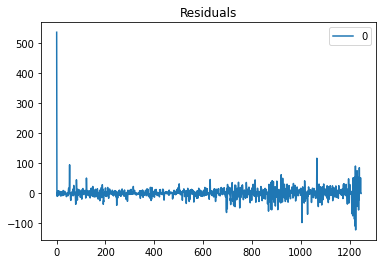

In [11]:
###### ANALYZE ARIMA RESIDUALS TO DETERMINE IF GARCH SHOULD BE USED

# Plot residual errors
plotResiduals=symbolFolder+"/plot_ARIMA_residuals_"+symbol+".pdf"
residualTrain=pd.DataFrame(autoARIMA.resid())
residualTrain.plot(title="Residuals")
pyplot.savefig(plotResiduals, bbox_inches='tight')
pyplot.show()

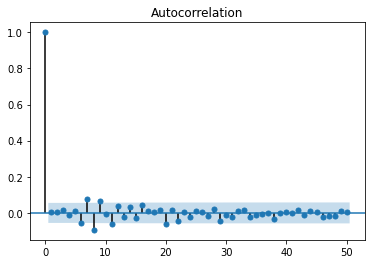

In [12]:
# Plot autocorrelation function (ACF). Here on ARIMA residuals.
plotACF=symbolFolder+"/plot_ACF_ARIMA_residuals_"+symbol+".pdf"
plot_acf(residualTrain,lags=50)
pyplot.savefig(plotACF, bbox_inches='tight')
pyplot.show()

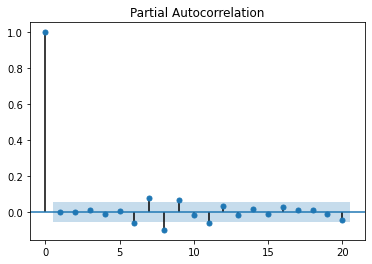

In [13]:
# Plot partial autocorrelations (PACF). Here on ARIMA residuals.
plotPACF=symbolFolder+"/plot_PACF_ARIMA_residuals_"+symbol+".pdf"
plot_pacf(residualTrain,lags=20)
pyplot.savefig(plotPACF, bbox_inches='tight')
pyplot.show()

In [15]:
###### BUILD GARCH MODEL
# A GARCH model should be built if autocorrelation on residuals was previously found. 

# Build GARCH model and finding automatically the best GARCH model 
squaredResidualTrain=residualTrain**2
squaredResidualTrain.ix=squaredResidualTrain.iloc # allows to fix a bug of pyflux package with pandas package!
pmax=4
qmax=6
aicModels = np.zeros( ((pmax-1)*(qmax-1), 3) )
k=0
for p in range(1, pmax):
    for q in range(1, qmax):
        GARCHmodel = pf.GARCH(squaredResidualTrain,p=p,q=q)
        aicModels[k,0]=p
        aicModels[k,1]=q
        aicModels[k,2]=GARCHmodel.fit().aic
        k=k+1

print("GARCH models and corresponding AICs:")
print(aicModels)
bestParams=aicModels[np.argmin(aicModels[:,2]),:]
print("\nBest GARCH parameters: p=" + str(int(bestParams[0])) + ", q=" + str(int(bestParams[1])))

GARCH models and corresponding AICs:
[[1.00000000e+00 1.00000000e+00 2.00425138e+04]
 [1.00000000e+00 2.00000000e+00 2.00304219e+04]
 [1.00000000e+00 3.00000000e+00 2.01555825e+04]
 [1.00000000e+00 4.00000000e+00 2.00704893e+04]
 [1.00000000e+00 5.00000000e+00 1.99945239e+04]
 [2.00000000e+00 1.00000000e+00 5.51429715e+05]
 [2.00000000e+00 2.00000000e+00 5.51428031e+05]
 [2.00000000e+00 3.00000000e+00 3.28079501e+05]
 [2.00000000e+00 4.00000000e+00 2.66588729e+05]
 [2.00000000e+00 5.00000000e+00 3.93126281e+05]
 [3.00000000e+00 1.00000000e+00 1.41777905e+05]
 [3.00000000e+00 2.00000000e+00 1.41802776e+05]
 [3.00000000e+00 3.00000000e+00 1.41825679e+05]
 [3.00000000e+00 4.00000000e+00 1.17929023e+05]
 [3.00000000e+00 5.00000000e+00 1.67193943e+05]]

Best GARCH parameters: p=1, q=5


In [16]:
# Best GARCH model
GARCHbestmodel = pf.GARCH(squaredResidualTrain,p=int(bestParams[0]),q=int(bestParams[1]))
print(GARCHbestmodel.fit().summary())

Hessian not invertible! Consider a different model specification.

GARCH(1,5)                                                                                                
======================================================= ==================================================
Dependent Variable: 0                                   Method: MLE                                       
Start Date: 5                                           Log Likelihood: -9989.262                         
End Date: 1247                                          AIC: 19994.523912978486                           
Number of observations: 1243                            BIC: 20035.526177710573                           
Latent Variable                          Estimate  
======================================== ==========
Vol Constant                             5599.5687 
q(1)                                     0.0261    
q(2)                                     0.0       
q(3)                           

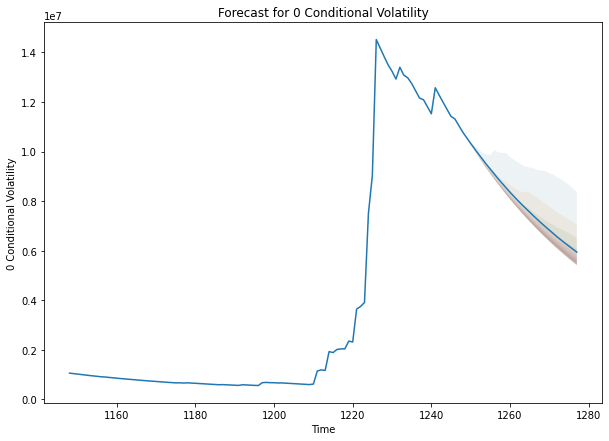

In [17]:
###### FORECAST PRICE VARIANCE (VOLATILITY) USING GARCH MODEL

# Plot predictions of future conditional volatility
GARCHbestmodel.plot_predict(h=kdays, past_values=100, intervals=True)

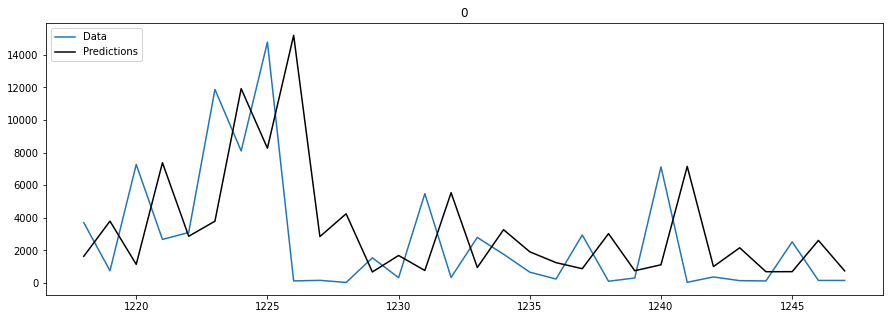

In [18]:
# View how well we predicted using in-sample rolling prediction
GARCHbestmodel.plot_predict_is(h=kdays,figsize=(15,5))

In [20]:
# GARCH best model (using another python module that allows to store GARCH forecasting)
GARCHbestmodel2 = arch_model(squaredResidualTrain, vol='Garch', p=int(bestParams[0]), 
                                      o=0, q=int(bestParams[1]), dist='Normal')
GARCHbestmodel2fit = GARCHbestmodel2.fit(update_freq=5)
#print(GARCHbestmodel2.fit().summary())

Iteration:      5,   Func. Count:     52,   Neg. LLF: 10379.891368491746
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 10379.891135602607
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 5


In [21]:
# GARCH forecasting
GARCHforecasts = GARCHbestmodel2fit.forecast(horizon=kdays)
print(GARCHforecasts.mean.iloc[len(squaredResidualTrain)-1,0:20])

h.01    519.016381
h.02    519.016381
h.03    519.016381
h.04    519.016381
h.05    519.016381
h.06    519.016381
h.07    519.016381
h.08    519.016381
h.09    519.016381
h.10    519.016381
h.11    519.016381
h.12    519.016381
h.13    519.016381
h.14    519.016381
h.15    519.016381
h.16    519.016381
h.17    519.016381
h.18    519.016381
h.19    519.016381
h.20    519.016381
Name: 1247, dtype: float64
